## Mvanack Code Review

In [2]:
# suppress warning messages from pymc3
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import numpy as np
import pandas as pd
import pymc3 as pm
import toyplot

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


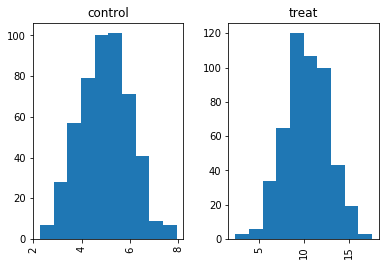

In [4]:
# set random seed
np.random.seed(4321)

# true values for mean and sd of two variables
nsize = 500
true_mu1 = 5
true_mu2 = 10
true_sig1 = 1
true_sig2 = 2.5

# generate variables
control = np.random.normal(true_mu1, true_sig1, nsize)
treat   = np.random.normal(true_mu2, true_sig2, nsize)

data = pd.DataFrame(dict(value=np.r_[control, treat], group=np.r_[['control']*nsize, ['treat']*nsize]))

# plot histograms by group
data.hist('value', by='group');


In [5]:
mu_mean = data.value.mean()
mu_sd   = data.value.std() * 2

with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', mu_mean, sd=mu_sd)
    group2_mean = pm.Normal('group2_mean', mu_mean, sd=mu_sd)

In [6]:
sig_low = 0
sig_high = 10

with model:
    group1_std = pm.Uniform('group1_std', lower=sig_low, upper=sig_high)
    group2_std = pm.Uniform('group2_std', lower=sig_low, upper=sig_high)

In [7]:
with model:
    ν = pm.Exponential('ν_minus_one', 1/29.) + 1


In [8]:
with model:
    lam1 = group1_std**-2
    lam2 = group2_std**-2

    group1 = pm.StudentT('control', nu=ν, mu=group1_mean, lam=lam1, observed=control)
    group2 = pm.StudentT('treat', nu=ν, mu=group2_mean, lam=lam2, observed=treat)


In [9]:
with model:
    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)



In [10]:
with model:
    trace = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν_minus_one_log__, group2_std_interval__, group1_std_interval__, group2_mean, group1_mean]
100%|██████████| 3500/3500 [00:07<00:00, 467.66it/s]


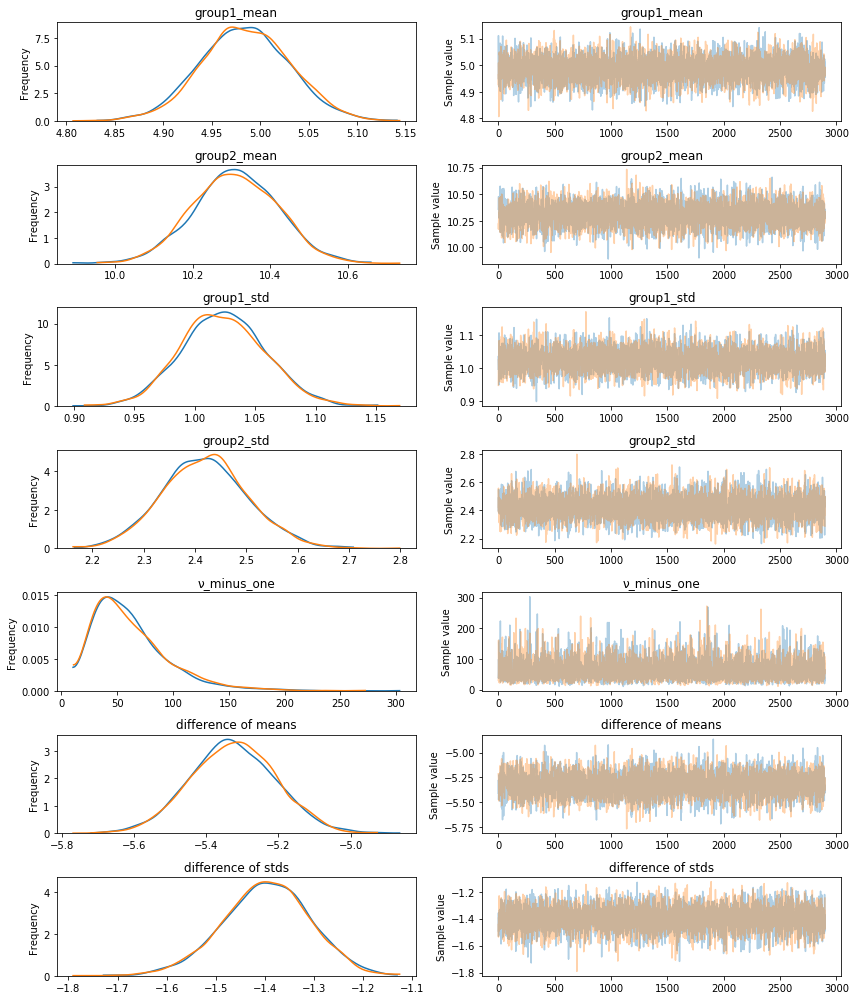

In [11]:
pm.traceplot(trace[100:]);

In [12]:
pm.summary(trace[100:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
group1_mean,4.984341,0.045774,0.000606,4.895560,5.074660,5276.0,1.000106
group2_mean,10.309519,0.108825,0.001413,10.082465,10.506589,5800.0,0.999837
group1_std,1.023550,0.034460,0.000481,0.954904,1.088739,5477.0,0.999864
group2_std,2.420250,0.083375,0.001112,2.259237,2.586313,5800.0,0.999955
ν_minus_one,62.847885,34.020552,0.376423,13.519634,129.109742,5800.0,0.999940
difference of means,-5.325178,0.117572,0.001482,-5.549828,-5.093103,5800.0,0.999914
difference of stds,-1.396700,0.088016,0.001187,-1.567665,-1.223421,5800.0,0.999998


**What method did they use to generate data? What types of distributions did they sample data from? What type of data do these distributions generate?**

Alex used a normal distribution to sample from and used the numpy.random.normal method to generate the data. He also uses the students T distrubution to set the distribution of the group scores because pymc requires a precision parameter instead of a standard deviation. 

He generated two datasets, a normal and a treatment group, to examine the difference between the groups' means. The two groups are composed of continuous data with 500 datapoints each, the maximum range of both groups falls below 20. 

**What type of model did they try to fit with pymc3? Did they link to the tutorial that their analysis is based on. Which parameters of the model are they trying to fit. **


He was fitting a deterministic model where he looked at the difference between the means and standard deviations of teh datasets. He did provide a link to the tutorial to the online tutorial. The model parameters he fit were group means and standard deviations, the difference between group means and standard deviations and v minus 1 which was the range for the student T distribution. 


**Are the sampling data in their model from the same type of distribution that was used to generate the data?**

I don't think the sampled data in the model is in the same distribution as the generated data. It seems the sampled data used a student's T distribution and the generated data used a normal distribution. 


**Do you agree or disagree with their assessment of the model fit? Did it work well? How might you suggest improving the model, or further testing this type of model?**

Yes, I agree with his statement that the model did a good job at predicting the parameters set for the data. All of the group means and standard deviations were very close to the parameters he set.

Interpretting the results of the model would be nice to add to this. Also to develop the model further, comparing more than two treatment groups would be interesting to see.
